In [1]:
import numpy as np
import joblib
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
# Paths (hardcoded is OK in notebook)
PROJECT_DIR = Path.cwd().parents[0]  # adjust if needed
MODELS_DIR = PROJECT_DIR / "models"


# Load trained model & scaler
model = joblib.load(MODELS_DIR / "gain_model.pkl")
scaler = joblib.load(MODELS_DIR / "scaler.pkl")

print("Model and scaler loaded")

Model and scaler loaded


In [3]:
def predict_gain(pmos_w, nmos_w):
    X = np.array([[pmos_w, nmos_w]])
    X_scaled = scaler.transform(X)
    return model.predict(X_scaled)[0]


In [4]:
predict_gain(6e-6, 4e-6)


np.float64(14.437570000000038)

In [5]:
def objective(position, target_gain):
    pmos_w, nmos_w = position
    pred_gain = predict_gain(pmos_w, nmos_w)
    return abs(pred_gain - target_gain)


In [6]:
def pso_inverse(
    target_gain,
    bounds,
    n_particles=30,
    n_iters=100,
    w=0.7,       # inertia
    c1=1.5,      # cognitive
    c2=1.5,      # social
    tol = 0.01,
    seed=42
):
    np.random.seed(seed)

    dim = len(bounds)

    # Initialize particles
    positions = np.array([
        [np.random.uniform(b[0], b[1]) for b in bounds]
        for _ in range(n_particles)
    ])

    velocities = np.zeros_like(positions)

    # Personal bests
    pbest_positions = positions.copy()
    pbest_scores = np.array([
        objective(pos, target_gain) for pos in positions
    ])

    # Global best
    gbest_idx = np.argmin(pbest_scores)
    gbest_position = pbest_positions[gbest_idx].copy()
    gbest_score = pbest_scores[gbest_idx]

    history = []

    for it in range(n_iters):
        for i in range(n_particles):
            r1, r2 = np.random.rand(dim), np.random.rand(dim)

            velocities[i] = (
                w * velocities[i]
                + c1 * r1 * (pbest_positions[i] - positions[i])
                + c2 * r2 * (gbest_position - positions[i])
            )

            positions[i] += velocities[i]

            # Apply bounds
            for d in range(dim):
                positions[i, d] = np.clip(
                    positions[i, d],
                    bounds[d][0],
                    bounds[d][1]
                )

            score = objective(positions[i], target_gain)

            if score < pbest_scores[i]:
                pbest_scores[i] = score
                pbest_positions[i] = positions[i].copy()

        # Update global best
        best_idx = np.argmin(pbest_scores)
        if pbest_scores[best_idx] < gbest_score:
            gbest_score = pbest_scores[best_idx]
            gbest_position = pbest_positions[best_idx].copy()

        history.append(gbest_score)

        # EARLY STOPPING CRITERION
    # -------------------------------
        if gbest_score <= tol:
            print(f"Early stopping at iteration {it} | Error: {gbest_score:.4f} dB")
            break

        if it % 10 == 0:
            print(f"Iter {it:03d} | Best Error: {gbest_score:.4f} dB")

    return gbest_position, gbest_score, history


In [7]:
bounds = [
    (1e-6, 20e-6),  # PMOS_W
    (1e-6, 20e-6),  # NMOS_W
]


In [20]:
target_gain = -10.0  # dB

best_pos, best_err, history = pso_inverse(
    target_gain=target_gain,
    bounds=bounds,
    n_particles=40,
    n_iters=120
)

pmos_w, nmos_w = best_pos
pred_gain = predict_gain(pmos_w, nmos_w)

print("\n==== Inverse Design Result ====")
print(f"Target Gain     : {target_gain} dB")
print(f"PMOS Width      : {pmos_w:.3e}")
print(f"NMOS Width      : {nmos_w:.3e}")
print(f"Predicted Gain  : {pred_gain:.3f} dB")
print(f"Absolute Error  : {best_err:.4f} dB")


Iter 000 | Best Error: 0.1887 dB
Iter 010 | Best Error: 0.0266 dB
Early stopping at iteration 12 | Error: 0.0049 dB

==== Inverse Design Result ====
Target Gain     : -10.0 dB
PMOS Width      : 1.189e-05
NMOS Width      : 1.858e-05
Predicted Gain  : -9.995 dB
Absolute Error  : 0.0049 dB


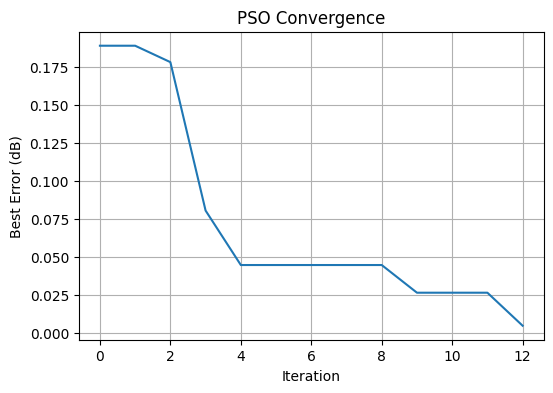

In [21]:
plt.figure(figsize=(6,4))
plt.plot(history)
plt.xlabel("Iteration")
plt.ylabel("Best Error (dB)")
plt.title("PSO Convergence")
plt.grid(True)
plt.show()

In [24]:
for tg in [5, 10, 15]:
    print(f"\nTarget: {tg} dB")
    best_pos, best_err, _ = pso_inverse(
        target_gain=tg,
        bounds=bounds,
        n_particles=30,
        n_iters=100,
        seed=42
    )

    pmos_w, nmos_w = best_pos
    pred_gain = predict_gain(pmos_w, nmos_w)

    print(f"PMOS_W: {pmos_w:.3e}, NMOS_W: {nmos_w:.3e}")
    print(f"Predicted Gain: {pred_gain:.3f} dB | Error: {best_err:.3f}")



Target: 5 dB
Iter 000 | Best Error: 0.8724 dB
Iter 010 | Best Error: 0.1652 dB
Iter 020 | Best Error: 0.0315 dB
Iter 030 | Best Error: 0.0315 dB
Iter 040 | Best Error: 0.0315 dB
Iter 050 | Best Error: 0.0315 dB
Iter 060 | Best Error: 0.0315 dB
Iter 070 | Best Error: 0.0315 dB
Iter 080 | Best Error: 0.0315 dB
Iter 090 | Best Error: 0.0315 dB
PMOS_W: 2.387e-06, NMOS_W: 1.884e-06
Predicted Gain: 4.969 dB | Error: 0.031

Target: 10 dB
Iter 000 | Best Error: 0.2526 dB
Iter 010 | Best Error: 0.0192 dB
Iter 020 | Best Error: 0.0192 dB
Iter 030 | Best Error: 0.0192 dB
Iter 040 | Best Error: 0.0192 dB
Iter 050 | Best Error: 0.0192 dB
Iter 060 | Best Error: 0.0192 dB
Iter 070 | Best Error: 0.0192 dB
Iter 080 | Best Error: 0.0192 dB
Iter 090 | Best Error: 0.0192 dB
PMOS_W: 1.299e-05, NMOS_W: 9.623e-06
Predicted Gain: 9.981 dB | Error: 0.019

Target: 15 dB
Iter 000 | Best Error: 0.6157 dB
Iter 010 | Best Error: 0.0238 dB
Iter 020 | Best Error: 0.0238 dB
Iter 030 | Best Error: 0.0238 dB
Iter 040 |